<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/Amazon_Cell_Phone_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Libraries

In [3]:
from __future__ import print_function

import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from oauth2client.client import GoogleCredentials

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '17-i-_a2zKwXJCNoOCt6R-Ezr2swO8x8r'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('items.csv')

file_id = '1flTqx4fnPVrk5zyydJDvh67z4IIN-2Ei'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.csv')

# Mount the drive to access files
drive_colab.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

## File Upload
Upload all the required files

In [0]:
reviews = pd.read_csv('reviews.csv')
items = pd.read_csv('items.csv')

## Items Dataset
Ratings is numerical and mostly others are strings.   
No significant NA's in this dataset.  
We see Samsung has the highest phones with 346.  
Motorola is second with 105 and Apple has 63 phones.  

In [0]:
items.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
totalReviews       int64
price            float64
originalPrice    float64
dtype: object

In [0]:
items.shape

(720, 10)

In [0]:
items.isna().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [0]:
  items.groupby('brand').agg({'asin':['count'], 'rating':['mean']})

,asin,rating
,count,mean
brand,,
ASUS,5,3.860000
Apple,63,3.782540
Google,38,3.771053
HUAWEI,32,4.021875
Motorola,105,3.643810
Nokia,44,3.386364
OnePlus,10,3.580000
Samsung,346,3.632659


## Reviews Dataset
Mostly string features.  
Very few NA's and can be ignored compared to rest of data.  


In [0]:
reviews.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
dtype: object

In [0]:
reviews.isna().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [0]:
reviews.shape

(67986, 8)

## Merged Dataset

In [0]:
df = pd.merge(reviews, items, on='asin')
brand_count = df.groupby('brand').agg({'asin':['count'], 'rating_x':['mean']}).reset_index()
brand_count.columns = ["_".join(x) for x in brand_count.columns.ravel()]
brand_count.sort_values(by='asin_count',ascending=False)
df.shape

(67986, 17)

## Cleaning

In [0]:
df_reviews = df['body'].reset_index()
df_reviews.head()
df_reviews['body'] = df_reviews['body'].fillna("")
df_reviews['word_count'] = 0
df_reviews['most_common'] = ""
df_reviews['common_count'] = 0

In [0]:
df_reviews.head()

,index,body,word_count,most_common,common_count
0,0,I had the Samsung A600 for awhile which is abs...,0,,0
1,1,Due to a software issue between Nokia and Spri...,0,,0
2,2,"This is a great, reliable phone. I also purcha...",0,,0
3,3,"I love the phone and all, because I really did...",0,,0
4,4,The phone has been great for every purpose it ...,0,,0


In [0]:
stop_words = set(stopwords.words("english"))
for i in range(df_reviews.shape[0]):
    #Pick reviews one-by-one
    rev = df_reviews.iloc[i,1]
    
    # Make text lowercase, remove punctuation and remove words containing numbers
    rev = rev.lower()
    rev = rev.replace("."," .")
    rev = rev.replace("’"," ’")
    rev = re.sub('[%s]' % re.escape(string.punctuation), '', rev)
    rev = re.sub('\w*\d\w*', '', rev)

    # Tokenize the review
    tok_rev = word_tokenize(rev)
    
    #remove stop words
    filtered_rev = []
    for w in tok_rev:
        if w not in stop_words:
            filtered_rev.append(w)
    
    #Compute number of words
    df_reviews.iloc[i,2] = len(filtered_rev)
    
    #Find the most common word and its count
    fdist = FreqDist(filtered_rev)
    
    if len(filtered_rev) > 1:
        df_reviews.iloc[i,3] = fdist.most_common(1)[0][0]
        df_reviews.iloc[i,4] = fdist.most_common(1)[0][1]
    else:
        df_reviews.iloc[i,3] = ""
        df_reviews.iloc[i,4] = 0

KeyboardInterrupt: ignored

In [0]:
df_reviews.head()

,index,body,word_count,most_common,common_count
0,0,I had the Samsung A600 for awhile which is abs...,166,phone,7
1,1,Due to a software issue between Nokia and Spri...,68,sprint,3
2,2,"This is a great, reliable phone. I also purcha...",69,phone,3
3,3,"I love the phone and all, because I really did...",44,phone,5
4,4,The phone has been great for every purpose it ...,57,get,5


In [0]:
df_reviews['word_count'].mean()

28.143558968022827

In [0]:
top_words = df_reviews.groupby('most_common').agg({'index':['count']})
top_words.columns = ["_".join(x) for x in top_words.columns.ravel()]
top_words = top_words.sort_values(by='index_count',ascending=False)

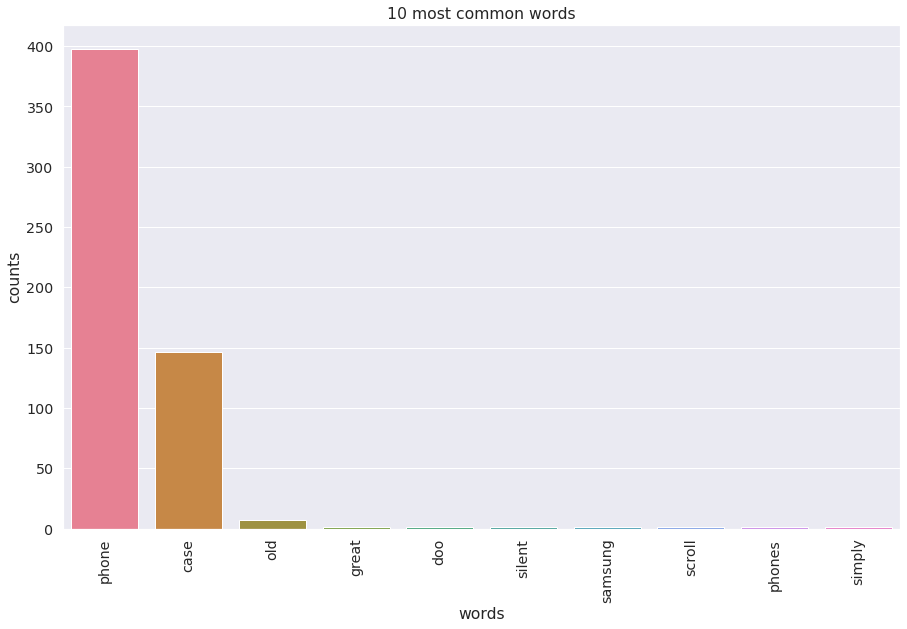

In [0]:
def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()
count_vectorizer = CountVectorizer(stop_words='english')  
count_data = count_vectorizer.fit_transform(df_reviews['body'])
plot_10_most_common_words(count_data, count_vectorizer)

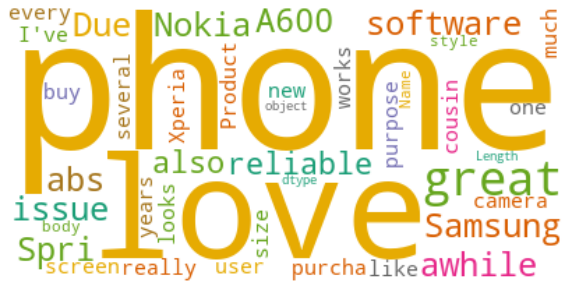

In [0]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
wc.generate(str(df_reviews.body))
plt.figure( figsize=(10,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modeling

In [40]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Just importing, imputing and cleaning the data again. Not required but for testing purposes

In [8]:
items_df=items.copy()
reviews_df=reviews.copy()
items_df['brand'] = np.where((items_df.asin == 'B0000SX2UC'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B01EWKHIAI'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07JHXX5YR'),'ASUS',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07T3KMJW8'),'Xiaomi',items_df.brand)
merged_data=pd.merge (items_df,reviews_df,how='left',on='asin')
merged_data.shape

(67986, 17)

In [0]:
merged_data=merged_data.rename(columns={'rating_x': 'Average_Rating','rating_y':'Customer_Rating','title_x':'Product_Name','title_y':'Review_title'})

## Cleaning using NLTK

Need to clean the reviews - lower case,remove punctuations and keywords like brand name, phone and finally lemmatize

In [61]:
import spacy
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer("english")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
keywords = merged_data["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    # Convert the text into lowercase
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_key]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)
clean_text('This is our collaboratory notebook for Data Mining Project. Okay you should be excited reading this!')

'collaboratory notebook data mining project okay excited reading'

In [62]:
keywords

['nokia',
 'motorola',
 'samsung',
 'huawei',
 'sony',
 'apple',
 'google',
 'asus',
 'oneplus',
 'xiaomi',
 'phone']

In [0]:
merged_data["body"] = merged_data["body"].astype("str")
merged_data["clean_text"] = merged_data["body"].apply(clean_text)
merged_data["positivity"] = merged_data["Customer_Rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

Creating an Apple only dataset

In [0]:
merged_data["clean_text"].head().values
apple = merged_data[merged_data["brand"]=="Apple"].sort_values(by=["date"], ascending=False)

In [65]:
apple.head()

,asin,brand,Product_Name,url,image,Average_Rating,reviewUrl,totalReviews,price,originalPrice,name,Customer_Rating,date,verified,Review_title,body,helpfulVotes,clean_text,positivity
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine,1
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger,1
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,stolen tossed owner att stated owner owes unlo...,-1
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1


In [66]:
clean_text('Fuck that was good!')

'fuck good'

In [67]:
clean_text('No no thats not how you clean. Delete it')

'thats clean delete'

## Ngrams and Wordclouds


In [68]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(apple["clean_text"], 10)
for word, freq in common_words:
    print(word, freq)



brand new 366
battery life 359
like new 318
sim card 214
work great 176
screen protector 150
perfect condition 117
look like 111
battery health 100
good condition 92


In [69]:
df4 = pd.DataFrame(common_words, columns = ['Bigrams' , 'count'])
df4.head()

,Bigrams,count
0,brand new,366
1,battery life,359
2,like new,318
3,sim card,214
4,work great,176


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

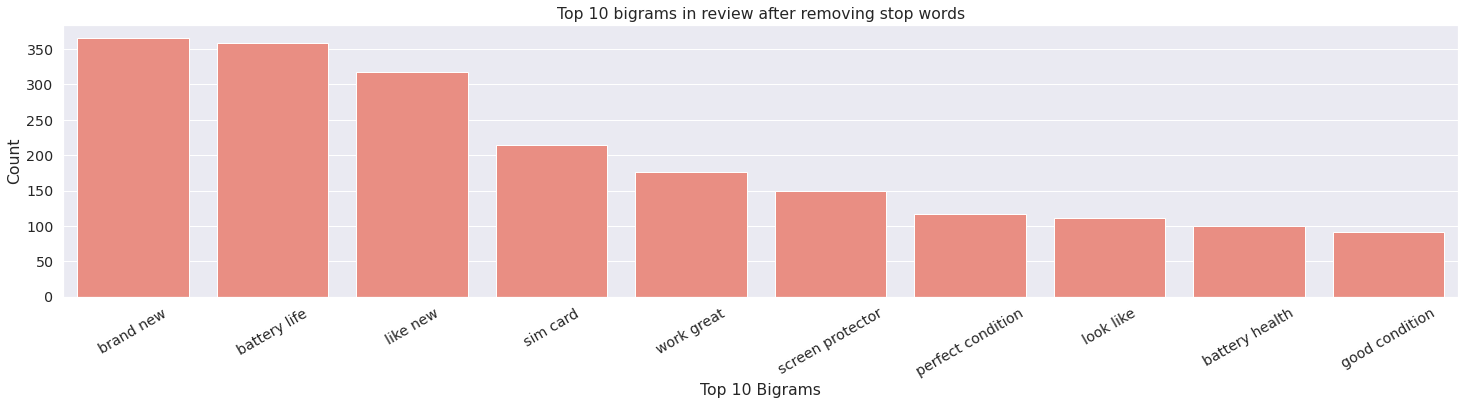

In [71]:
plt.figure(figsize=(25,5))
sns.barplot(x='Bigrams',y='count',data=df4,color="salmon")
plt.xlabel('Top 10 Bigrams')
plt.ylabel('Count')
plt.title('Top 10 bigrams in review after removing stop words')
plt.xticks(rotation=30);


In [72]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigrams = get_top_n_trigram(apple["clean_text"], 10)
for word, freq in common_words_trigrams:
    print(word, freq)

df5 = pd.DataFrame(common_words_trigrams, columns = ['Trigrams' , 'count'])
df5.head()

like brand new 84
look brand new 83
look like new 61
work like new 57
looked brand new 37
came screen protector 35
like new condition 26
brand new scratch 23
came perfect condition 23
glass screen protector 21


,Trigrams,count
0,like brand new,84
1,look brand new,83
2,look like new,61
3,work like new,57
4,looked brand new,37


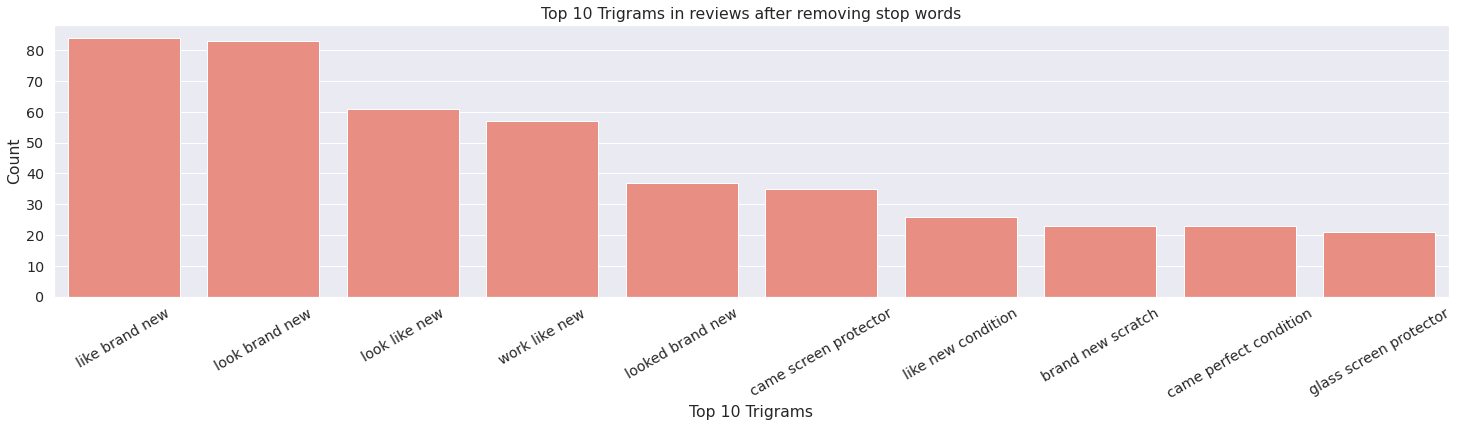

In [73]:
plt.figure(figsize=(25,5))
sns.barplot(x='Trigrams',y='count',data=df5,color="salmon")
plt.xlabel('Top 10 Trigrams')
plt.ylabel('Count')
plt.title('Top 10 Trigrams in reviews after removing stop words')
plt.xticks(rotation=30);

In [0]:
from wordcloud import WordCloud, ImageColorGenerator

# Define a function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
# Define a function to plot top10 positive words and top10 negative words in a grouped bar plot (from dictionaries)
def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transform positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    # Transform negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

In [0]:
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict

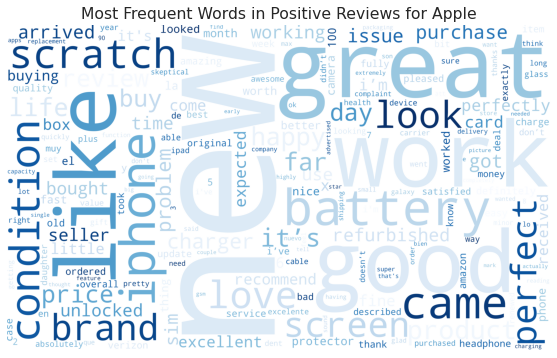

In [129]:
apple_pos = " ".join(apple[apple["positivity"]==1]["clean_text"])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in Positive Reviews for Apple")

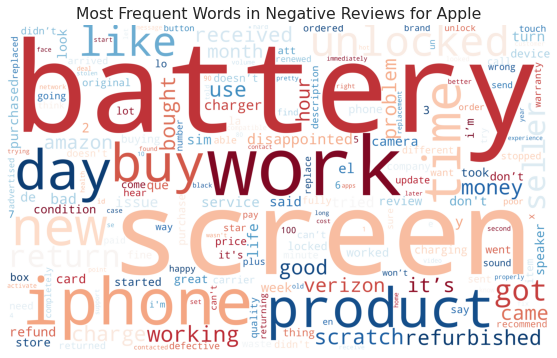

In [128]:
apple_neg = " ".join(apple[apple["positivity"]==-1]["clean_text"])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="RdBu",
                      background_color="white")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in Negative Reviews for Apple")

# LDA - Latent Dirichlet Allocation

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=60, 
                                learning_method='online',
                                learning_offset=60.0,
                                n_jobs=1,
                                random_state=0,learning_decay=0.5)


In [0]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]])
        print(message)
    print()

In [92]:
apple_topics = tfidf_vectorizer.fit_transform(apple["clean_text"])
apple_feature_names = tfidf_vectorizer.get_feature_names()
lda.fit(apple_topics)
print("Below is the output from LDA model with {} topics (each includes Top10 words) for Apple.".format(n_topics))
show_topics(lda, apple_feature_names, 10)


Below is the output from LDA model with 10 topics (each includes Top10 words) for Apple.
Topic #0: problem got price great iphone good came work new like
Topic #1: unlocked working day work use bought came time charger far
Topic #2: good new like look brand work came scratch charger battery
Topic #3: screen scratch time battery life work like new charger came
Topic #4: issue purchase review battery new came iphone happy great like
Topic #5: great work came charger brand battery bought new good day
Topic #6: product refurbished happy bought work buy iphone good came like
Topic #7: love buy seller new work came iphone good day bought
Topic #8: iphone battery use bought day new life work good came
Topic #9: condition perfect far good work came scratch happy bought new



# Ratings Prediction from reviews

In [0]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [125]:
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', LogisticRegression(solver='newton-cg', multi_class='multinomial'))])
X = apple['clean_text']
y = apple['Customer_Rating']
review_trainLR, review_testLR, label_trainLR, label_testLR = train_test_split(X, y, test_size=0.3, random_state=101)
pipeline.fit(review_trainLR, label_trainLR)
pipe_predictedLR = pipeline.predict(review_testLR)
print(metrics.classification_report(label_testLR,pipe_predictedLR))
scores_LR = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5,scoring=('r2', 'neg_mean_squared_error'))
#print(scores_LR['test_score'].mean())
print(scores_LR['test_r2'].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.52      0.30      0.38       357
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00       176
           5       0.60      0.95      0.73       849

    accuracy                           0.59      1544
   macro avg       0.22      0.25      0.22      1544
weighted avg       0.45      0.59      0.49      1544

-0.4473772842462781


Naive Bayes Model

In [118]:
#Multinomial Naive Bayes 
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', MultinomialNB())
])
X2 = apple['clean_text']
y2 = apple['Customer_Rating']
review_train2, review_test2, label_train2, label_test2 = train_test_split(X2, y2, test_size=0.3)
pipeline.fit(review_train2, label_train2)
pip_pred2 = pipeline.predict(review_test2)
print(metrics.classification_report(label_test2, pip_pred2))
scores_NB = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5)
print(scores_NB['test_score'].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      0.01      0.01       335
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        99
           4       0.00      0.00      0.00       158
           5       0.57      1.00      0.73       882

    accuracy                           0.57      1544
   macro avg       0.31      0.20      0.15      1544
weighted avg       0.54      0.57      0.42      1544

0.5533527696793004


Random Forest model

In [117]:
# RandomForest
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', RandomForestClassifier())])
X3 = apple['clean_text']
y3 = apple['Customer_Rating']
review_trainRF, review_testRF, label_trainRF, label_testRF = train_test_split(X3, y3, test_size=0.3)
pipeline.fit(review_trainRF, label_trainRF)
pipeline_predictedRF= pipeline.predict(review_testRF)
print(metrics.classification_report(label_testRF, pipeline_predictedRF))
scores_RF = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5)
print(scores_RF['test_score'].mean())

              precision    recall  f1-score   support

           1       0.67      0.41      0.51       356
           2       1.00      0.12      0.22        80
           3       1.00      0.16      0.28        94
           4       0.77      0.15      0.25       154
           5       0.65      0.96      0.78       860

    accuracy                           0.66      1544
   macro avg       0.82      0.36      0.41      1544
weighted avg       0.71      0.66      0.60      1544

0.5968901846452866
